<a href="https://colab.research.google.com/github/DrAlexSanz/Happy-house/blob/master/Smile_detector_using_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import numpy as np
import keras


import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [18, 12]
import h5py

from PIL import Image

from keras import layers, optimizers
from keras.layers import Input, Dense, Conv2D, Activation, ZeroPadding2D, BatchNormalization, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D

from keras.models import Model, Sequential

from keras.preprocessing import image

from keras.utils import layer_utils, plot_model

from keras.callbacks import History, ModelCheckpoint

keras.backend.set_image_data_format('channels_last')

%matplotlib inline

print("Everything imported correctly")

Everything imported correctly


Load the data, kill the previous files and clone github repo.

In [57]:
#First remove the folder and everything it contains.

!rm -rf Happy-house

#Now I clone the repository and everything works.

! git clone https://github.com/DrAlexSanz/Happy-house.git

Cloning into 'Happy-house'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 34 (delta 10), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (34/34), done.


Now read data.



In [58]:
#Now read data

with h5py.File("Happy-house/test_happy.h5") as test:
  test_x_1 = np.array(test["test_set_x"][:]) # your train set features
  test_y_1 = np.array(test["test_set_y"][:]) # your train set labels
  classes = np.array(test["list_classes"][:]) # the list of classes

with h5py.File("Happy-house/train_happy.h5") as train:
  train_x_1 = np.array(train["train_set_x"][:]) # train set features
  train_y_1 = np.array(train["train_set_y"][:]) # train set labels

print("Everything loaded and imported")

Everything loaded and imported


Load one picture to check.

y = 0


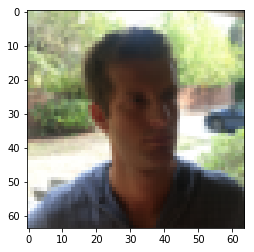

In [59]:
plt.imshow(train_x_1[450])
print("y = " + str(train_y_1[450]))

In [0]:
#Normalize

train_x = train_x_1/255
test_x = test_x_1/255

train_y = train_y_1
test_y = test_y_1

y = 1


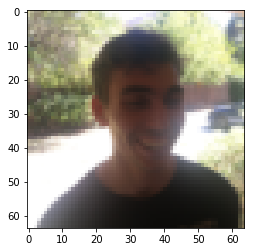

In [61]:
plt.imshow(train_x[13])
print("y = " + str(train_y[13]))

Just for this time, after normalizing I won't see any difference in my picture. It's only a change of scale.

In [62]:
print("X train shape is: " + str(train_x.shape))
print("Y train shape is: " + str(train_y.shape))
print("X test shape is: " + str(test_x.shape))
print("Y test shape is: " + str(test_y.shape))

X train shape is: (600, 64, 64, 3)
Y train shape is: (600,)
X test shape is: (150, 64, 64, 3)
Y test shape is: (150,)


So I have 600 (+ 150 test) pictures of 64x64 in 3 colours.

Now I will create a model in Keras that fits/predicts if the picture is "smily". The topology of the network is:



1.   CONV, RELU, BatchNorm (x2)
2.   Fully connected with a sigmoid because I predict 0 or 1 (1 layer, to be changed later).

Batch norm is a way to isolate the layers from each other. This way, layer 3 does not affect layer 356 (for example) too much. If not used, this may cause exploding or vanishing gradients. This can be seen as in the chain rule, layer 1 depends on all the previous (following) layers. With a batch norm I decouple the system. There's a video by Ian Goodfellow and another by Andrew Ng, very good.



In [0]:
def happy_model(Input_Shape):
  """
  The function implements the model for the happy house. Note that in TF I had the placeholders and all the X -> Z -> A
  Here I use X to overwrite the values. This is how Keras works.
  
  Input is the shape of the images
  
  Output is the model() instance
  """
  
  filters_layer_1 = 32
  size_filter = 3
  dropout_prob = 0
  
  x_input = Input_Shape
  
  model = Sequential()
  
  #First conv, relu, BN
  
  model.add(Conv2D(filters_layer_1, kernel_size = (size_filter, size_filter), padding = "same", strides = (1, 1), input_shape = (x_input, x_input, 3), name = "Conv_1"))
            
  model.add(Activation("relu", name = "relu_1"))
            
  model.add(BatchNormalization(name = "BN_1"))
  
  model.add(MaxPooling2D(pool_size=(2,2), name = "MaxPool_1"))
  
  model.add(Dropout(0.2, name = "Drop_1"))
            
  #Second conv, relu, BN
  
  model.add(Conv2D(2 * filters_layer_1, kernel_size = (2*size_filter, 2*size_filter), padding = "same", strides = (3, 3), input_shape = (x_input, x_input, 3), name = "Conv_2"))
            
  model.add(Activation("relu", name = "relu_2"))
            
  model.add(BatchNormalization(name = "BN_2"))
  
  model.add(MaxPooling2D(pool_size=(2,2), name = "MaxPool_2"))
  
  model.add(Dropout(0.2, name = "Drop_2"))
            
  #Flatten and FC layer
            
  model.add(Flatten(name = "Flatten"))
  
  model.add(Dense(1, activation = "sigmoid", name = "FC_1"))
          
  return model
  
  

In [0]:
def happy_model2(Input_Shape):
  """
  The function implements the model for the happy house. Note that in TF I had the placeholders and all the X -> Z -> A
  Here I use X to overwrite the values. This is how Keras works.
  
  Input is the shape of the images
  
  Output is the model() instance
  """
  
  filters_layer_1 = 32
  size_filter = 3
  dropout_prob = 0
  
  x_input = Input_Shape
  
  model = Sequential()
  
  #First conv, relu, BN
  
  model.add(Conv2D(filters_layer_1, kernel_size = (size_filter, size_filter), padding = "same", strides = (1, 1), input_shape = (x_input, x_input, 3)))
            
  model.add(Activation("relu"))
            
  model.add(BatchNormalization())
  
  model.add(MaxPooling2D(pool_size=(2,2)))
            
  #Second conv, relu, BN
  
  model.add(Conv2D(2 * filters_layer_1, kernel_size = (2*size_filter, 2*size_filter), padding = "same", strides = (3, 3), input_shape = (x_input, x_input, 3)))
            
  model.add(Activation("relu"))
            
  model.add(BatchNormalization())
  
  model.add(MaxPooling2D(pool_size=(2,2)))
  
  #Third conv, relu, BN
  
  model.add(Conv2D(3 * filters_layer_1, kernel_size = (3*size_filter, 3*size_filter), padding = "same", strides = (5, 5), input_shape = (x_input, x_input, 3)))
            
  model.add(Activation("relu"))
            
  model.add(BatchNormalization())

            
  #Flatten and FC layer
            
  model.add(Flatten())
  
#   model.add(Dense(100, activation = "tanh"))
  
  model.add(Dense(1, activation = "sigmoid"))
          
  return model
  
  

Now I have to create the model. Then I can train it and use it to predict.

In [65]:
happy = happy_model(train_x.shape[1])


# happy = happy_model2(train_x.shape[1])

# happy = happy_model2(64)

happy.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
relu_1 (Activation)          (None, 64, 64, 32)        0         
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 64, 64, 32)        128       
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 32, 32, 32)        0         
_________________________________________________________________
Drop_1 (Dropout)             (None, 32, 32, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        73792     
_________________________________________________________________
relu_2 (Activation)          (None, 11, 11, 64)        0         
__________

Now I will plot the model to make sure I created what I wanted to create

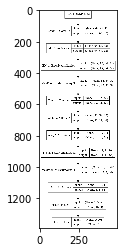

In [66]:
plot_model(happy, show_shapes = True, to_file = "model.png")

model_plot = Image.open("model.png")

plt.imshow(model_plot)

So far it doesn't complain. Let's compile it.

In [0]:
opti = optimizers.Adam(lr = 1e-3)

checkpointer = ModelCheckpoint(filepath = "best_weights.h5", monitor = "val_acc", save_best_only = True)

happy.compile(loss = "binary_crossentropy", optimizer = opti, metrics = ["accuracy"])
hist = History()

In [68]:
num_epochs = 50

happy.fit(train_x, train_y, batch_size = 64, epochs = num_epochs, validation_data = (test_x, test_y), shuffle = True, callbacks = [hist, checkpointer])

Train on 600 samples, validate on 150 samples
Epoch 1/50
600/600 [==============================] - 1s 1ms/step - loss: 1.2772 - acc: 0.5817 - val_loss: 0.8947 - val_acc: 0.6467
Epoch 2/50
600/600 [==============================] - 0s 290us/step - loss: 0.4576 - acc: 0.7917 - val_loss: 0.3730 - val_acc: 0.8200
Epoch 3/50
600/600 [==============================] - 0s 292us/step - loss: 0.3164 - acc: 0.8717 - val_loss: 0.3288 - val_acc: 0.8533
Epoch 4/50
600/600 [==============================] - 0s 266us/step - loss: 0.2724 - acc: 0.8850 - val_loss: 0.3923 - val_acc: 0.8133
Epoch 5/50
600/600 [==============================] - 0s 259us/step - loss: 0.1924 - acc: 0.9233 - val_loss: 0.2956 - val_acc: 0.8733
Epoch 6/50
600/600 [==============================] - 0s 253us/step - loss: 0.1606 - acc: 0.9567 - val_loss: 0.2678 - val_acc: 0.9067
Epoch 7/50
600/600 [==============================] - 0s 255us/step - loss: 0.1501 - acc: 0.9550 - val_loss: 0.2466 - val_acc: 0.9067
Epoch 8/50
600/600

And it trains ok. It's a super simple network so it goes fast. I'll do a more complicated one later. It may not be necessary but it's good to play with all the parameters.

In [69]:
#Make sure I have the best weights loaded

happy.load_weights("best_weights.h5")
pred = happy.evaluate(test_x, test_y)
print("Loss is: " + str(pred[0]))
print("Accuracy is: " + str(pred[1]))

150/150 [==============================] - 0s 169us/step
Loss is: 0.08752168118953704
Accuracy is: 0.98


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


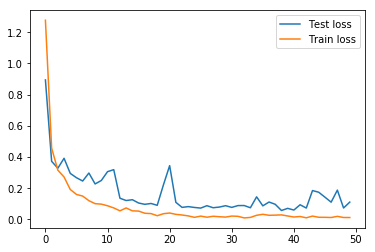

In [70]:
print(hist.history.keys())

plt.figure();

plt.plot(range(num_epochs), list(hist.history.values())[0], label = "Test loss");
plt.plot(range(num_epochs), list(hist.history.values())[2], label = "Train loss");
plt.legend(loc = "best")

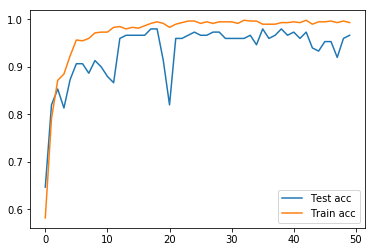

In [71]:
plt.figure();

plt.plot(range(num_epochs), list(hist.history.values())[1], label = "Test acc");
plt.plot(range(num_epochs), list(hist.history.values())[3], label = "Train acc");
plt.legend(loc = "best")

Now let's see if the model predicts correctly, with just a few pictures.

I would normally put this whole process into one or two functions but here I won't do it. It's just to try it so I will probably work more unnecesarily.

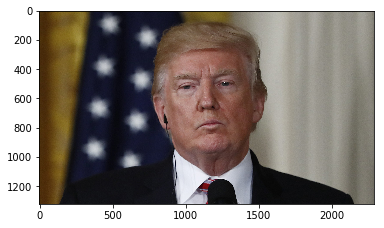

In [72]:
#Serious image. Let's see. First load, then resize to 64x64 and then predict.
ser = Image.open("Happy-house/serious.jpg")
plt.imshow(ser)

Original size is:  (2290, 1322)
New size is:  (64, 64)


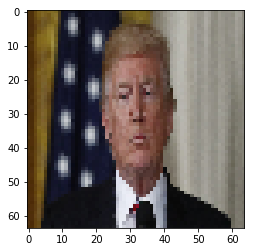

In [73]:
#Resize to 64 x 64

print("Original size is: ", ser.size)

ser_res = ser.resize((64, 64))

print("New size is: ", ser_res.size)

ser_res = np.asarray(ser_res) #So far it was an image and I want an array
ser_res = ser_res/255 # It was all normalized before

plt.imshow(ser_res)

Now predict.

In [74]:
# Keras wants a tensor of (n_pictures, height, width, colours). So far I have only the last 3 dimensions

ser_res = np.expand_dims(ser_res, axis=0)

pred_serious = happy.predict(ser_res)



print("The class is: ", pred_serious)

The class is:  [[0.9975068]]


So the model predicted 99.9% probability, which is to say class 1, which is smile according to the convention in the dataset. Now let's do the same thing with the smiling picture. Let's see another serious person.

Original size is:  (269, 269)
New size is:  (64, 64)
The class is:  [[0.9639591]]


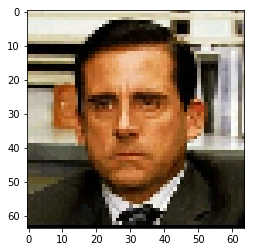

In [75]:
#Reuse variable name. Not best practice but it's ok for this.
ser = Image.open("Happy-house/serious2.jpg")
plt.imshow(ser)

#Resize to 64 x 64

print("Original size is: ", ser.size)

ser_res = ser.resize((64, 64))

print("New size is: ", ser_res.size)

ser_res = np.asarray(ser_res) #So far it was an image and I want an array
ser_res = ser_res/255 # It was all normalized before

plt.imshow(ser_res)

# Keras wants a tensor of (n_pictures, height, width, colours). So far I have only the last 3 dimensions

ser_res = np.expand_dims(ser_res, axis=0)

pred_serious = happy.predict(ser_res)



print("The class is: ", pred_serious)

Original size is:  (4208, 3120)


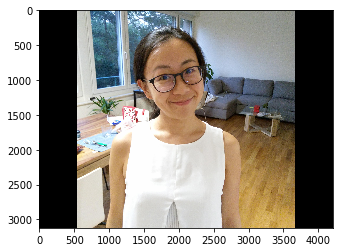

In [76]:
#Reuse variable name. Not best practice but it's ok for this.
ser = Image.open("Happy-house/sm_s.jpg")
ser.rotate(270).save("Happy-house/sm_s.jpg")
ser = Image.open("Happy-house/sm_s.jpg")
plt.imshow(ser)

#Resize to 64 x 64

print("Original size is: ", ser.size)



New size is:  (64, 64)
The class is:  [[0.9937356]]


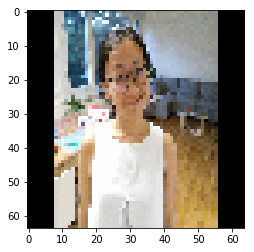

In [77]:
ser_res = ser.resize((64, 64))

print("New size is: ", ser_res.size)

ser_res = np.asarray(ser_res) #So far it was an image and I want an array
ser_res = ser_res/255 # It was all normalized before

plt.imshow(ser_res)

# Keras wants a tensor of (n_pictures, height, width, colours). So far I have only the last 3 dimensions

ser_res = np.expand_dims(ser_res, axis=0)

pred_serious = happy.predict(ser_res)



print("The class is: ", pred_serious)

Original size is:  (4208, 3120)


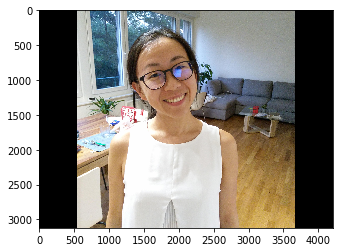

In [78]:
#Reuse variable name. Not best practice but it's ok for this.
ser = Image.open("Happy-house/sm_s2.jpg")
ser.rotate(270).save("Happy-house/sm_s.jpg")
ser = Image.open("Happy-house/sm_s.jpg")
plt.imshow(ser)

#Resize to 64 x 64

print("Original size is: ", ser.size)



New size is:  (64, 64)
The class is:  [[0.99983275]]


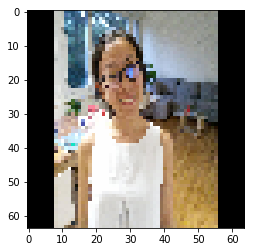

In [79]:
ser_res = ser.resize((64, 64))

print("New size is: ", ser_res.size)

ser_res = np.asarray(ser_res) #So far it was an image and I want an array
ser_res = ser_res/255 # It was all normalized before

plt.imshow(ser_res)

# Keras wants a tensor of (n_pictures, height, width, colours). So far I have only the last 3 dimensions

ser_res = np.expand_dims(ser_res, axis=0)

pred_serious = happy.predict(ser_res)



print("The class is: ", pred_serious)

Original size is:  (4208, 3120)


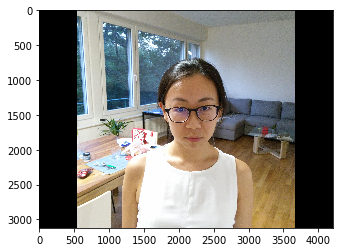

In [80]:
#Reuse variable name. Not best practice but it's ok for this.
ser = Image.open("Happy-house/sm_s3.jpg")
ser.rotate(270).save("Happy-house/sm_s.jpg")
ser = Image.open("Happy-house/sm_s.jpg")
plt.imshow(ser)

#Resize to 64 x 64

print("Original size is: ", ser.size)



New size is:  (64, 64)
The class is:  [[0.6333889]]


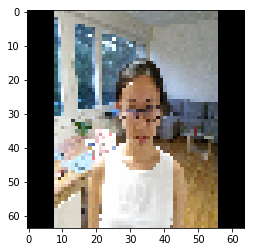

In [81]:
ser_res = ser.resize((64, 64))

print("New size is: ", ser_res.size)

ser_res = np.asarray(ser_res) #So far it was an image and I want an array
ser_res = ser_res/255 # It was all normalized before

plt.imshow(ser_res)

# Keras wants a tensor of (n_pictures, height, width, colours). So far I have only the last 3 dimensions

ser_res = np.expand_dims(ser_res, axis=0)

pred_serious = happy.predict(ser_res)



print("The class is: ", pred_serious)

RGBA


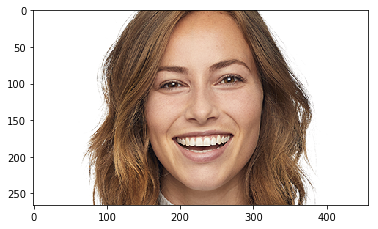

In [82]:
#Smile image. Let's see. First load, then resize to 64x64 and then predict.
smi = Image.open("Happy-house/smile.png")
plt.imshow(smi)
print(smi.mode)

I just noticed that the image is RGBA, not RGB. I didn't know that mode existed. Anyway, convert it. In the future I can check it at testing or preprocessing time with an if, for example.

Original size is:  (457, 266)
New size is:  (64, 64)


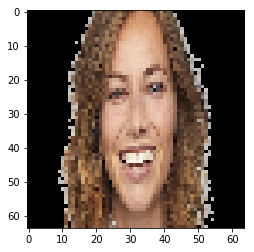

In [83]:
#Resize to 64 x 64
smi = smi.convert("RGB")

print("Original size is: ", smi.size)

smi_res = smi.resize((64, 64))

print("New size is: ", smi_res.size)

smi_res = np.asarray(smi_res) #So far it was an image and I want an array
smi_res = smi_res/255 # It was all normalized before

plt.imshow(smi_res)

Notice the conversion leaves a black background. Let's see how this works with the predictions.

In [84]:
# Keras wants a tensor of (n_pictures, height, width, colours). So far I have only the last 3 dimensions

smi_res = np.expand_dims(smi_res, axis=0)

pred_smi = happy.predict(smi_res)

print("The class is: ", pred_smi)

The class is:  [[0.9999882]]


CORRECT!! And high probability.

RGB


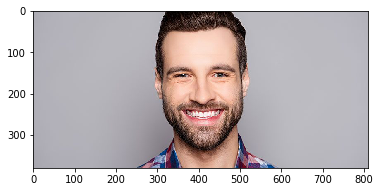

In [85]:
#Smile image. Let's see. First load, then resize to 64x64 and then predict.
smi2 = Image.open("Happy-house/smiling2.jpg")
plt.imshow(smi2)
print(smi2.mode)

Original size is:  (810, 380)
New size is:  12288


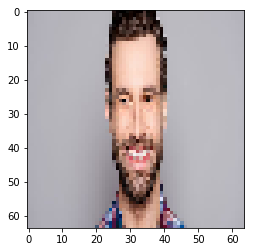

In [86]:
#Resize to 64 x 64

print("Original size is: ", smi2.size)

smi2_res = smi2.resize((64, 64))

print("New size is: ", smi_res.size)

smi2_res = np.asarray(smi2_res) #So far it was an image and I want an array
smi2_res = smi2_res/255 # It was all normalized before

plt.imshow(smi2_res)

In [87]:
# Keras wants a tensor of (n_pictures, height, width, colours). So far I have only the last 3 dimensions

smi2_res = np.expand_dims(smi2_res, axis=0)

pred_smi2 = happy.predict(smi2_res)

print("The probability is: ", pred_smi2)


The probability is:  [[0.50165355]]


RGB


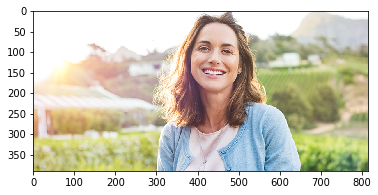

In [88]:
#Smile image. Let's see. First load, then resize to 64x64 and then predict.
smi2 = Image.open("Happy-house/smilingispowerful.jpg")
plt.imshow(smi2)
print(smi2.mode)

Original size is:  (816, 390)
New size is:  12288


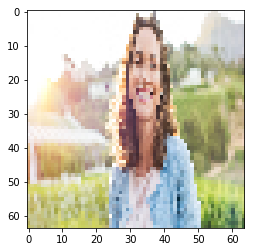

In [89]:
#Resize to 64 x 64

print("Original size is: ", smi2.size)

smi2_res = smi2.resize((64, 64))

print("New size is: ", smi_res.size)

smi2_res = np.asarray(smi2_res) #So far it was an image and I want an array
smi2_res = smi2_res/255 # It was all normalized before

plt.imshow(smi2_res)

In [90]:
# Keras wants a tensor of (n_pictures, height, width, colours). So far I have only the last 3 dimensions

smi2_res = np.expand_dims(smi2_res, axis=0)

pred_smi2 = happy.predict(smi2_res)

print("The probability is: ", pred_smi2)

The probability is:  [[0.65245354]]


Somehow this model doesn't predict smiling people too well. I will try to tune the model a bit and change the dimensions of the layers and then re run the whole thing (happy2). Interesting.

Also, the resizing of the image may play a role here. The proportions of the train/test set are not the same as the ones I am using. However, it's not too bad.

Now I'll try to see the intermediate activations. I use the one with the best weights because otherwise it doesn't make a lot of sense.

In [91]:
layer_outputs = [layer.output for layer in happy.layers[:8]]

activ = Model(inputs=happy.input, outputs=layer_outputs)
# Creates a model that will return these outputs, given the model input

activ = activ.predict(ser_res)

first_layer_activation = activ[0]
print(first_layer_activation.shape)

(1, 64, 64, 32)


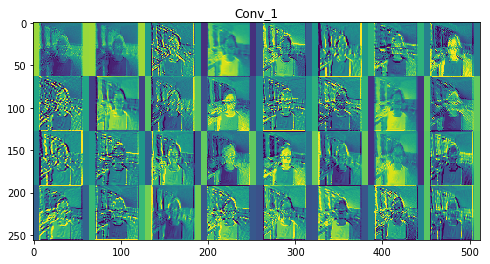

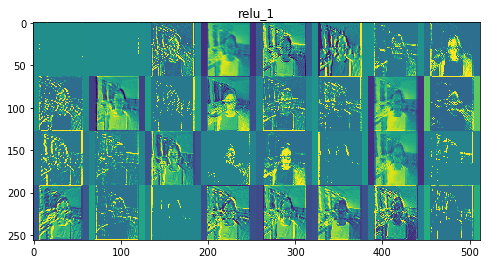

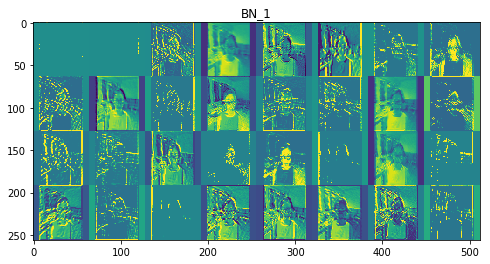

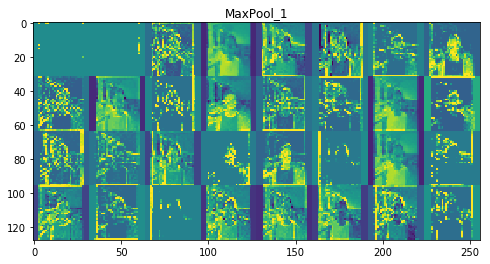

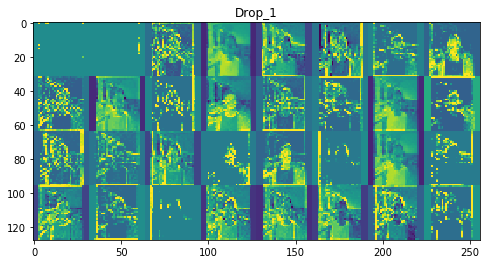

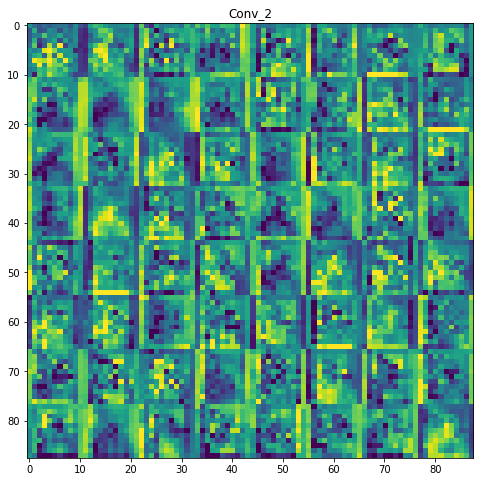

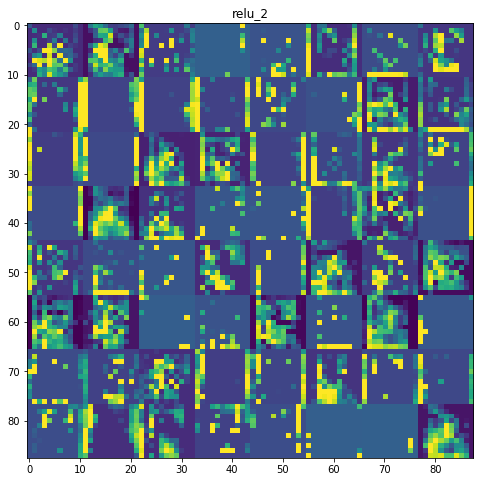

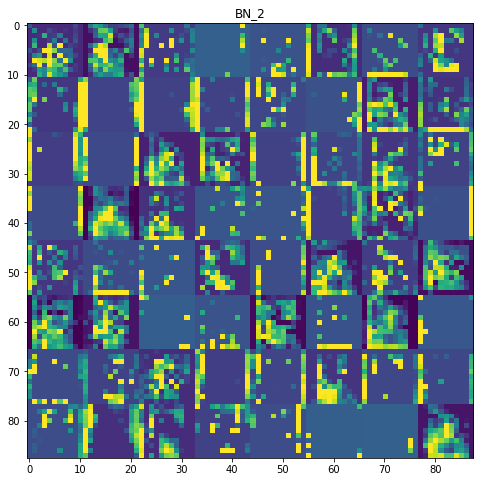

In [92]:
layer_names = []
for layer in happy.layers[:8]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 8

for layer_name, layer_activation in zip(layer_names, activ): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

I see that most of the deeper learning is very abstract. And also there are many blue/green activations. This is because there are not many things left to learn anymore. If I put a few more layers downstream they would tend to be all blue. And then also vanishing gradients huehuehue.
This suggests me to use dropout.